# ML for Gas Adsorption

## -1. Only if you run this notebook on Colab

If you use this notebook on Colab, please uncomment the lines below (remove the `#`) and execute the cell.

In [4]:
#import sys
#!{sys.executable} -m pip install -U pandas-profiling[notebook]
#!jupyter nbextension enable --py widgetsnbextension
#!pip install --upgrade pandas sklearn holoviews bokeh plotly matplotlib
#!wget https://raw.githubusercontent.com/kjappelbaum/ml_molsim/2022/descriptornames.py
#!mkdir data
#!cd data && wget https://github.com/kjappelbaum/ml_molsim/raw/2022/data/data.csv
#!cd data && wget https://github.com/kjappelbaum/ml_molsim/raw/2022/data/features.csv
# import os, holoviews as hv
# os.environ['HV_DOC_HTML'] = 'true'

## Import packages we will need

In [5]:
# basics
import os
import numpy as np
import pprint as pp

# pandas is used to read/process data
import pandas as pd

# machine learning dependencies
# scaling of data
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
# train/test split0
from sklearn.model_selection import train_test_split
# model selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# the KRR model
from sklearn.kernel_ridge import KernelRidge
# linear model
from sklearn.linear_model import LinearRegression
# pipeline to streamline modeling pipelines
from sklearn.pipeline import Pipeline
# principal component analysis
from sklearn.decomposition import PCA
# polynomial kernel
from sklearn.metrics.pairwise import polynomial_kernel
# Dummy model as baseline
from sklearn.dummy import DummyClassifier, DummyRegressor
# Variance Threshold for feature selection
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
# metrics to measure model performance
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             mean_absolute_error, mean_squared_error, max_error)

# save/load models
import joblib

# For the permutation importance implementation
from joblib import Parallel
from joblib import delayed
from sklearn.metrics import check_scoring
from sklearn.utils import Bunch
from sklearn.utils import check_random_state
from sklearn.utils import check_array

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
from pymatviz.parity import hist_density

RANDOM_SEED = 4242424242
DATA_DIR = 'data'
DATA_FILE = os.path.join(DATA_DIR, 'data.csv')

np.random.seed(RANDOM_SEED)


In [14]:
## other_descriptors = ["CellV [A^3]"]

geometric_descriptors = [
    "Di",
    "Df",
    "Dif",
    "density [g/cm^3]",
    "total_SA_volumetric",
    "total_SA_gravimetric",
    "total_POV_volumetric",
    "total_POV_gravimetric",
]

linker_descriptors = [
    "f-lig-chi-0",
    "f-lig-chi-1",
    "f-lig-chi-2",
    "f-lig-chi-3",
    "f-lig-Z-0",
    "f-lig-Z-1",
    "f-lig-Z-2",
    "f-lig-Z-3",
    "f-lig-I-0",
    "f-lig-I-1",
    "f-lig-I-2",
    "f-lig-I-3",
    "f-lig-T-0",
    "f-lig-T-1",
    "f-lig-T-2",
    "f-lig-T-3",
    "f-lig-S-0",
    "f-lig-S-1",
    "f-lig-S-2",
    "f-lig-S-3",
    "lc-chi-0-all",
    "lc-chi-1-all",
    "lc-chi-2-all",
    "lc-chi-3-all",
    "lc-Z-0-all",
    "lc-Z-1-all",
    "lc-Z-2-all",
    "lc-Z-3-all",
    "lc-I-0-all",
    "lc-I-1-all",
    "lc-I-2-all",
    "lc-I-3-all",
    "lc-T-0-all",
    "lc-T-1-all",
    "lc-T-2-all",
    "lc-T-3-all",
    "lc-S-0-all",
    "lc-S-1-all",
    "lc-S-2-all",
    "lc-S-3-all",
    "lc-alpha-0-all",
    "lc-alpha-1-all",
    "lc-alpha-2-all",
    "lc-alpha-3-all",
    "D_lc-chi-0-all",
    "D_lc-chi-1-all",
    "D_lc-chi-2-all",
    "D_lc-chi-3-all",
    "D_lc-Z-0-all",
    "D_lc-Z-1-all",
    "D_lc-Z-2-all",
    "D_lc-Z-3-all",
    "D_lc-I-0-all",
    "D_lc-I-1-all",
    "D_lc-I-2-all",
    "D_lc-I-3-all",
    "D_lc-T-0-all",
    "D_lc-T-1-all",
    "D_lc-T-2-all",
    "D_lc-T-3-all",
    "D_lc-S-0-all",
    "D_lc-S-1-all",
    "D_lc-S-2-all",
    "D_lc-S-3-all",
    "D_lc-alpha-0-all",
    "D_lc-alpha-1-all",
    "D_lc-alpha-2-all",
    "D_lc-alpha-3-all",
]

metalcenter_descriptors = [
    "mc_CRY-chi-0-all",
    "mc_CRY-chi-1-all",
    "mc_CRY-chi-2-all",
    "mc_CRY-chi-3-all",
    "mc_CRY-Z-0-all",
    "mc_CRY-Z-1-all",
    "mc_CRY-Z-2-all",
    "mc_CRY-Z-3-all",
    "mc_CRY-I-0-all",
    "mc_CRY-I-1-all",
    "mc_CRY-I-2-all",
    "mc_CRY-I-3-all",
    "mc_CRY-T-0-all",
    "mc_CRY-T-1-all",
    "mc_CRY-T-2-all",
    "mc_CRY-T-3-all",
    "mc_CRY-S-0-all",
    "mc_CRY-S-1-all",
    "mc_CRY-S-2-all",
    "mc_CRY-S-3-all",
    "D_mc_CRY-chi-0-all",
    "D_mc_CRY-chi-1-all",
    "D_mc_CRY-chi-2-all",
    "D_mc_CRY-chi-3-all",
    "D_mc_CRY-Z-0-all",
    "D_mc_CRY-Z-1-all",
    "D_mc_CRY-Z-2-all",
    "D_mc_CRY-Z-3-all",
    "D_mc_CRY-I-0-all",
    "D_mc_CRY-I-1-all",
    "D_mc_CRY-I-2-all",
    "D_mc_CRY-I-3-all",
    "D_mc_CRY-T-0-all",
    "D_mc_CRY-T-1-all",
    "D_mc_CRY-T-2-all",
    "D_mc_CRY-T-3-all",
    "D_mc_CRY-S-0-all",
    "D_mc_CRY-S-1-all",
    "D_mc_CRY-S-2-all",
    "D_mc_CRY-S-3-all",
]

functionalgroup_descriptors = [
    "func-chi-0-all",
    "func-chi-1-all",
    "func-chi-2-all",
    "func-chi-3-all",
    "func-Z-0-all",
    "func-Z-1-all",
    "func-Z-2-all",
    "func-Z-3-all",
    "func-I-0-all",
    "func-I-1-all",
    "func-I-2-all",
    "func-I-3-all",
    "func-T-0-all",
    "func-T-1-all",
    "func-T-2-all",
    "func-T-3-all",
    "func-S-0-all",
    "func-S-1-all",
    "func-S-2-all",
    "func-S-3-all",
    "func-alpha-0-all",
    "func-alpha-1-all",
    "func-alpha-2-all",
    "func-alpha-3-all",
    "D_func-chi-0-all",
    "D_func-chi-1-all",
    "D_func-chi-2-all",
    "D_func-chi-3-all",
    "D_func-Z-0-all",
    "D_func-Z-1-all",
    "D_func-Z-2-all",
    "D_func-Z-3-all",
    "D_func-I-0-all",
    "D_func-I-1-all",
    "D_func-I-2-all",
    "D_func-I-3-all",
    "D_func-T-0-all",
    "D_func-T-1-all",
    "D_func-T-2-all",
    "D_func-T-3-all",
    "D_func-S-0-all",
    "D_func-S-1-all",
    "D_func-S-2-all",
    "D_func-S-3-all",
    "D_func-alpha-0-all",
    "D_func-alpha-1-all",
    "D_func-alpha-2-all",
    "D_func-alpha-3-all",
]


summed_linker_descriptors = [
    "sum-f-lig-chi-0",
    "sum-f-lig-chi-1",
    "sum-f-lig-chi-2",
    "sum-f-lig-chi-3",
    "sum-f-lig-Z-0",
    "sum-f-lig-Z-1",
    "sum-f-lig-Z-2",
    "sum-f-lig-Z-3",
    "sum-f-lig-I-0",
    "sum-f-lig-I-1",
    "sum-f-lig-I-2",
    "sum-f-lig-I-3",
    "sum-f-lig-T-0",
    "sum-f-lig-T-1",
    "sum-f-lig-T-2",
    "sum-f-lig-T-3",
    "sum-f-lig-S-0",
    "sum-f-lig-S-1",
    "sum-f-lig-S-2",
    "sum-f-lig-S-3",
    "sum-lc-chi-0-all",
    "sum-lc-chi-1-all",
    "sum-lc-chi-2-all",
    "sum-lc-chi-3-all",
    "sum-lc-Z-0-all",
    "sum-lc-Z-1-all",
    "sum-lc-Z-2-all",
    "sum-lc-Z-3-all",
    "sum-lc-I-0-all",
    "sum-lc-I-1-all",
    "sum-lc-I-2-all",
    "sum-lc-I-3-all",
    "sum-lc-T-0-all",
    "sum-lc-T-1-all",
    "sum-lc-T-2-all",
    "sum-lc-T-3-all",
    "sum-lc-S-0-all",
    "sum-lc-S-1-all",
    "sum-lc-S-2-all",
    "sum-lc-S-3-all",
    "sum-lc-alpha-0-all",
    "sum-lc-alpha-1-all",
    "sum-lc-alpha-2-all",
    "sum-lc-alpha-3-all",
    "sum-D_lc-chi-0-all",
    "sum-D_lc-chi-1-all",
    "sum-D_lc-chi-2-all",
    "sum-D_lc-chi-3-all",
    "sum-D_lc-Z-0-all",
    "sum-D_lc-Z-1-all",
    "sum-D_lc-Z-2-all",
    "sum-D_lc-Z-3-all",
    "sum-D_lc-I-0-all",
    "sum-D_lc-I-1-all",
    "sum-D_lc-I-2-all",
    "sum-D_lc-I-3-all",
    "sum-D_lc-T-0-all",
    "sum-D_lc-T-1-all",
    "sum-D_lc-T-2-all",
    "sum-D_lc-T-3-all",
    "sum-D_lc-S-0-all",
    "sum-D_lc-S-1-all",
    "sum-D_lc-S-2-all",
    "sum-D_lc-S-3-all",
    "sum-D_lc-alpha-0-all",
    "sum-D_lc-alpha-1-all",
    "sum-D_lc-alpha-2-all",
    "sum-D_lc-alpha-3-all",
]

summed_metalcenter_descriptors = [
    "sum-mc_CRY-chi-0-all",
    "sum-mc_CRY-chi-1-all",
    "sum-mc_CRY-chi-2-all",
    "sum-mc_CRY-chi-3-all",
    "sum-mc_CRY-Z-0-all",
    "sum-mc_CRY-Z-1-all",
    "sum-mc_CRY-Z-2-all",
    "sum-mc_CRY-Z-3-all",
    "sum-mc_CRY-I-0-all",
    "sum-mc_CRY-I-1-all",
    "sum-mc_CRY-I-2-all",
    "sum-mc_CRY-I-3-all",
    "sum-mc_CRY-T-0-all",
    "sum-mc_CRY-T-1-all",
    "sum-mc_CRY-T-2-all",
    "sum-mc_CRY-T-3-all",
    "sum-mc_CRY-S-0-all",
    "sum-mc_CRY-S-1-all",
    "sum-mc_CRY-S-2-all",
    "sum-mc_CRY-S-3-all",
    "sum-D_mc_CRY-chi-0-all",
    "sum-D_mc_CRY-chi-1-all",
    "sum-D_mc_CRY-chi-2-all",
    "sum-D_mc_CRY-chi-3-all",
    "sum-D_mc_CRY-Z-0-all",
    "sum-D_mc_CRY-Z-1-all",
    "sum-D_mc_CRY-Z-2-all",
    "sum-D_mc_CRY-Z-3-all",
    "sum-D_mc_CRY-I-0-all",
    "sum-D_mc_CRY-I-1-all",
    "sum-D_mc_CRY-I-2-all",
    "sum-D_mc_CRY-I-3-all",
    "sum-D_mc_CRY-T-0-all",
    "sum-D_mc_CRY-T-1-all",
    "sum-D_mc_CRY-T-2-all",
    "sum-D_mc_CRY-T-3-all",
    "sum-D_mc_CRY-S-0-all",
    "sum-D_mc_CRY-S-1-all",
    "sum-D_mc_CRY-S-2-all",
    "sum-D_mc_CRY-S-3-all",
]

summed_functionalgroup_descriptors = [
    "sum-func-chi-0-all",
    "sum-func-chi-1-all",
    "sum-func-chi-2-all",
    "sum-func-chi-3-all",
    "sum-func-Z-0-all",
    "sum-func-Z-1-all",
    "sum-func-Z-2-all",
    "sum-func-Z-3-all",
    "sum-func-I-0-all",
    "sum-func-I-1-all",
    "sum-func-I-2-all",
    "sum-func-I-3-all",
    "sum-func-T-0-all",
    "sum-func-T-1-all",
    "sum-func-T-2-all",
    "sum-func-T-3-all",
    "sum-func-S-0-all",
    "sum-func-S-1-all",
    "sum-func-S-2-all",
    "sum-func-S-3-all",
    "sum-func-alpha-0-all",
    "sum-func-alpha-1-all",
    "sum-func-alpha-2-all",
    "sum-func-alpha-3-all",
    "sum-D_func-chi-0-all",
    "sum-D_func-chi-1-all",
    "sum-D_func-chi-2-all",
    "sum-D_func-chi-3-all",
    "sum-D_func-Z-0-all",
    "sum-D_func-Z-1-all",
    "sum-D_func-Z-2-all",
    "sum-D_func-Z-3-all",
    "sum-D_func-I-0-all",
    "sum-D_func-I-1-all",
    "sum-D_func-I-2-all",
    "sum-D_func-I-3-all",
    "sum-D_func-T-0-all",
    "sum-D_func-T-1-all",
    "sum-D_func-T-2-all",
    "sum-D_func-T-3-all",
    "sum-D_func-S-0-all",
    "sum-D_func-S-1-all",
    "sum-D_func-S-2-all",
    "sum-D_func-S-3-all",
    "sum-D_func-alpha-0-all",
    "sum-D_func-alpha-1-all",
    "sum-D_func-alpha-2-all",
    "sum-D_func-alpha-3-all",
]


 $\color{DarkBlue}{\textsf{Short question}}$
- We declared a global variable to fix the random seed (`RANDOM_SEED`). Why did we do this?

<span style="color:green">Answer:</span> So that any random process produces the same results when run. Any sequence called upon `np.random` will follow the same sequence of random numbers, yielding stable results.

## Hands-on Project: Carbon-dioxide uptake in MOFs

In this exercise we will build a model that can predict the CO$_2$ uptake of metal-organic frameworks (MOFs), which are crystalline materials consisting of inorganic metal nodes linked by organic linkers.

![MOF building principle](assets/mof_building_principle.png)

There are two main **learning goals** for this exercise: 

1. Understand the typical workflow for machine learning in materials science. We will cover exploratory data analysis (EDA) and supervised learning (KRR).

2. Get familiar with some Python packages that are useful for data analysis and visualization. 

At the end of the exercise, you will produce an interactive plot like the one below, comparing the predictions of your model against CO$_2$ computed with GCMC simulations.
The histograms show the distributions of the errors on the training set (left) and on the test set (right).



<img src="assets/result.gif" alt="Parity interactive" width="700"/>

This exercise requires a basic knowledge of Python, e.g. that you can write list comprehensions, and are able to read documentation of functions provided by Python packages.
You will be asked to provide some function arguments (indicated by `#fillme` comments).

You can execute all the following code cells by pressing SHIFT and ENTER and get informations about the functions by pressing TAB when you are between the parentheses (see the notes for more tips). 

Also the [sklearn documentation](https://scikit-learn.org/stable/user_guide.html) is a great source of reference with many explanations and examples.

In pandas dataframe (df) you can select columns using their name by running `df[columnname]`. If at any point you think that the dataset is too large for your computer, you can select a subset using `df.sample()` or by making the test set larger in the train/test split (section 2). 

## 1. Import the data

In [15]:
df = pd.read_csv(DATA_FILE)

Let's take a look at the first few rows to see if everythings seems reasonable ...

In [16]:
pd.options.display.max_columns=df.shape[1]
df.head()

,ASA [m^2/cm^3],CellV [A^3],Df,Di,Dif,NASA [m^2/cm^3],POAV [cm^3/g],POAVF,PONAV [cm^3/g],PONAVF,density [g/cm^3],MOFname,total_SA_volumetric,total_SA_gravimetric,total_POV_volumetric,total_POV_gravimetric,mc_CRY-chi-0-all,mc_CRY-chi-1-all,mc_CRY-chi-2-all,mc_CRY-chi-3-all,mc_CRY-Z-0-all,mc_CRY-Z-1-all,mc_CRY-Z-2-all,mc_CRY-Z-3-all,mc_CRY-I-0-all,mc_CRY-I-1-all,mc_CRY-I-2-all,mc_CRY-I-3-all,mc_CRY-T-0-all,mc_CRY-T-1-all,mc_CRY-T-2-all,mc_CRY-T-3-all,mc_CRY-S-0-all,mc_CRY-S-1-all,mc_CRY-S-2-all,mc_CRY-S-3-all,D_mc_CRY-chi-0-all,D_mc_CRY-chi-1-all,D_mc_CRY-chi-2-all,D_mc_CRY-chi-3-all,D_mc_CRY-Z-0-all,D_mc_CRY-Z-1-all,D_mc_CRY-Z-2-all,D_mc_CRY-Z-3-all,D_mc_CRY-I-0-all,D_mc_CRY-I-1-all,D_mc_CRY-I-2-all,D_mc_CRY-I-3-all,D_mc_CRY-T-0-all,D_mc_CRY-T-1-all,D_mc_CRY-T-2-all,D_mc_CRY-T-3-all,D_mc_CRY-S-0-all,D_mc_CRY-S-1-all,D_mc_CRY-S-2-all,D_mc_CRY-S-3-all,sum-mc_CRY-chi-0-all,sum-mc_CRY-chi-1-all,sum-mc_CRY-chi-2-all,sum-mc_CRY-chi-3-all,sum-mc_CRY-Z-0-all,sum-mc_CRY-Z-1-all,sum-mc_CRY-Z-2-all,sum-mc_CRY-Z-3-all,sum-mc_CRY-I-0-all,sum-mc_CRY-I-1-all,sum-mc_CRY-I-2-all,sum-mc_CRY-I-3-all,sum-mc_CRY-T-0-all,sum-mc_CRY-T-1-all,sum-mc_CRY-T-2-all,sum-mc_CRY-T-3-all,sum-mc_CRY-S-0-all,sum-mc_CRY-S-1-all,sum-mc_CRY-S-2-all,sum-mc_CRY-S-3-all,sum-D_mc_CRY-chi-0-all,sum-D_mc_CRY-chi-1-all,sum-D_mc_CRY-chi-2-all,sum-D_mc_CRY-chi-3-all,sum-D_mc_CRY-Z-0-all,sum-D_mc_CRY-Z-1-all,sum-D_mc_CRY-Z-2-all,sum-D_mc_CRY-Z-3-all,sum-D_mc_CRY-I-0-all,sum-D_mc_CRY-I-1-all,sum-D_mc_CRY-I-2-all,sum-D_mc_CRY-I-3-all,sum-D_mc_CRY-T-0-all,sum-D_mc_CRY-T-1-all,sum-D_mc_CRY-T-2-all,sum-D_mc_CRY-T-3-all,sum-D_mc_CRY-S-0-all,sum-D_mc_CRY-S-1-all,sum-D_mc_CRY-S-2-all,sum-D_mc_CRY-S-3-all,lc-chi-0-all,lc-chi-1-all,lc-chi-2-all,lc-chi-3-all,lc-Z-0-all,lc-Z-1-all,lc-Z-2-all,lc-Z-3-all,lc-I-0-all,lc-I-1-all,lc-I-2-all,lc-I-3-all,lc-T-0-all,lc-T-1-all,lc-T-2-all,lc-T-3-all,lc-S-0-all,lc-S-1-all,lc-S-2-all,lc-S-3-all,lc-alpha-0-all,lc-alpha-1-all,lc-alpha-2-all,lc-alpha-3-all,D_lc-chi-0-all,D_lc-chi-1-all,D_lc-chi-2-all,D_lc-chi-3-all,D_lc-Z-0-all,D_lc-Z-1-all,D_lc-Z-2-all,D_lc-Z-3-all,D_lc-I-0-all,D_lc-I-1-all,D_lc-I-2-all,D_lc-I-3-all,D_lc-T-0-all,D_lc-T-1-all,D_lc-T-2-all,D_lc-T-3-all,D_lc-S-0-all,D_lc-S-1-all,D_lc-S-2-all,D_lc-S-3-all,D_lc-alpha-0-all,D_lc-alpha-1-all,D_lc-alpha-2-all,D_lc-alpha-3-all,func-chi-0-all,func-chi-1-all,func-chi-2-all,func-chi-3-all,func-Z-0-all,func-Z-1-all,func-Z-2-all,func-Z-3-all,func-I-0-all,func-I-1-all,func-I-2-all,func-I-3-all,func-T-0-all,func-T-1-all,func-T-2-all,func-T-3-all,func-S-0-all,func-S-1-all,func-S-2-all,func-S-3-all,func-alpha-0-all,func-alpha-1-all,func-alpha-2-all,func-alpha-3-all,D_func-chi-0-all,D_func-chi-1-all,D_func-chi-2-all,D_func-chi-3-all,D_func-Z-0-all,D_func-Z-1-all,D_func-Z-2-all,D_func-Z-3-all,D_func-I-0-all,D_func-I-1-all,D_func-I-2-all,D_func-I-3-all,D_func-T-0-all,D_func-T-1-all,D_func-T-2-all,D_func-T-3-all,D_func-S-0-all,D_func-S-1-all,D_func-S-2-all,D_func-S-3-all,D_func-alpha-0-all,D_func-alpha-1-all,D_func-alpha-2-all,D_func-alpha-3-all,f-lig-chi-0,f-lig-chi-1,f-lig-chi-2,f-lig-chi-3,f-lig-Z-0,f-lig-Z-1,f-lig-Z-2,f-lig-Z-3,f-lig-I-0,f-lig-I-1,f-lig-I-2,f-lig-I-3,f-lig-T-0,f-lig-T-1,f-lig-T-2,f-lig-T-3,f-lig-S-0,f-lig-S-1,f-lig-S-2,f-lig-S-3,sum-lc-chi-0-all,sum-lc-chi-1-all,sum-lc-chi-2-all,sum-lc-chi-3-all,sum-lc-Z-0-all,sum-lc-Z-1-all,sum-lc-Z-2-all,sum-lc-Z-3-all,sum-lc-I-0-all,sum-lc-I-1-all,sum-lc-I-2-all,sum-lc-I-3-all,sum-lc-T-0-all,sum-lc-T-1-all,sum-lc-T-2-all,sum-lc-T-3-all,sum-lc-S-0-all,sum-lc-S-1-all,sum-lc-S-2-all,sum-lc-S-3-all,sum-lc-alpha-0-all,sum-lc-alpha-1-all,sum-lc-alpha-2-all,sum-lc-alpha-3-all,sum-D_lc-chi-0-all,sum-D_lc-chi-1-all,sum-D_lc-chi-2-all,sum-D_lc-chi-3-all,sum-D_lc-Z-0-all,sum-D_lc-Z-1-all,sum-D_lc-Z-2-all,sum-D_lc-Z-3-all,sum-D_lc-I-0-all,sum-D_lc-I-1-all,sum-D_lc-I-2-all,sum-D_lc-I-3-all,sum-D_lc-T-0-all,sum-D_lc-T-1-all,sum-D_lc-T-2-all,sum-D_lc-T-3-all,sum-D_lc-S-0-all,sum-D_lc-S-1-all,sum-D_lc-S-2-all,sum-D_lc-S-3-all,sum-D_lc-alpha-0-all,sum-D_lc-alpha-1-a

<details>
<summary> <font color='green'>Click here for a hint</font></summary>
<ul>
    <li>Use something like <code>pd.options.display.max_columns=100</code> to adjust how many columns are shown.<code>pd.options.display.max_columns=100</code>  would show at maximum 100 columns. </li>
</ul>
</details>

Let's also get some basic information ...

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Columns: 343 entries, ASA [m^2/cm^3] to CH4LPSTP
dtypes: float64(342), object(1)
memory usage: 45.5+ MB


 $\color{DarkBlue}{\textsf{Short question}}$
- How many materials are in the dataset?

<span style="color:green">Answer:</span> The dataset is made up of 17 379 entries, or materials.
- Which datatypes do we deal with?

<span style="color:green">Answer:</span> We deal with 342 float 64 and 1 object corresponding to the column categories.

Below, we define three global variables (hence upper case), which are the *names* of our feature and target columns. We will use the `TARGET` for the actual regression and the `TARGET_BINARY` only for the stratified train/test split. The `FEATURES` variable is a list of column names of our dataframe.

In [18]:
TARGET = "pure_uptake_CO2_298.00_1600000"
TARGET_BINARY = "target_binned"  # will be created later
FEATURES = (
    geometric_descriptors
    + summed_functionalgroup_descriptors
    + summed_linker_descriptors
    + summed_metalcenter_descriptors
)


As descriptors we will use geometric properties such as density, pore volume, etc. and [revised autocorrelation functions](https://pubs.acs.org/doi/abs/10.1021/acs.jpca.7b08750) (RACs) that have been optimized for describing inorganic compounds ([and recently adapated for MOFs](https://www.nature.com/articles/s41467-020-17755-8))

Examples for pore geometry descriptors (in `geometric_descriptors`) include: $D_i$ (the size of the largest included sphere), $D_f$ (the largest free sphere), and $D_{if}$ (the largest included free sphere) along the pore $-$ three ways of characterizing pore size. 

![pore diameters](assets/spheres.png)

Also included are the surface area (SA) of the pore, and the probe-occupiable pore volume (POV).
More details on the description of pore geometries can be found in [Ongari et al.](https://pubs.acs.org/doi/abs/10.1021/acs.langmuir.7b01682)

RACs (in the lists starting with `summed_...`) operate on the structure graph and encode information about the metal center, linkers and the functional groups as differences or products of heuristics that are relevant for inorganic chemistry, such as electronegativity ($\chi$), connectivity ($T$), identity ($I$), covalent radii ($S$), and nuclear charge ($Z$).


<img src="assets/racs.png" alt="RACs scheme from the lecture" width="700"/>

The number in the descriptornames shows the coordination shell that was considered in the calculation of the RACs.

The target we use for this application is the high-pressure CO$_2$ uptake. This is the amount of CO$_2$ (mmol) the MOF can load per gram.

## 2. Split the data

Next, we split our data into a training set and a test set.

In order to prevent *any* information of the test set from leaking into our model, we split *before* starting to analyze or transform our data. For more details on why this matters, see [chapter 7.10.2 of Elements of Statistical Learning](https://web.stanford.edu/~hastie/ElemStatLearn//printings/ESLII_print10.pdf).

### 2.1. Split with stratification

[Stratification](https://en.wikipedia.org/wiki/Stratified_sampling) ensures that the class distributions (ratio of "good" to "bad" materials) are the same in the training and test set.

 $\color{DarkBlue}{\textsf{Short question}}$

- Why is this important? What could happen if we would not do this?

<span style="color:green">Answer:</span> Stratification helps training the model with the same ratio of classes that will be found in the testing set. If strastification is not performed, it is to say, if one of the two sets, for instance the test set, has more "good" materials; the model may appear as performing well but would fail over "bad" materials. The same could happen the over way round yielding a poor model performance because it was only trained on "bad" materials.

For stratification to work, we to define what makes a "good" or a "bad" material. We will use 15 mmol CO
 / g as the threshold for the uptake, thus binarizing our continuous target variable. (You can choose it based on the histogram of the variables).
 

For stratification to work, we to define what makes a "good" or a "bad" material. We will use 15 mmol CO$_2$ / g as the threshold for the uptake, thus binarizing our continuous target variable. (You can choose it based on the histogram of the variables).

 $\color{DarkBlue}{\textsf{Short Exercise}}$
 - add a column 'target_binary' that encodes whether a material is low performing (`0`) or high perfoming (`1`) by comparing the uptake with the `THRESHOLD`

<details>
<summary> <font color='green'>Click here for a hint</font></summary>
<ul>
    <li> you can use <a href='https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html'>pd.cut</a>, 
    <a href='https://stackoverflow.com/questions/4406389/if-else-in-a-list-comprehension'>list comprehension</a>, the <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Binarizer.html#sklearn.preprocessing.Binarizer'> binarizer in sklearn </a>...) </li>
    <li> a list comprehension example: <code> [1 if value > THRESHOLD else 0 for value in df[TARGET]] </code> </li>
</ul>
</details>

In [19]:
THRESHOLD = 15 # in units of mmol CO2/g
df[TARGET_BINARY] = [1 if value > THRESHOLD else 0 for value in df[TARGET]]

Now, we can perform the actual split into training and test set.

### $\color{DarkBlue}{\textsf{Short Exercise}}$
- select reasonable values for `XX` and `XY` and then perform the test/train splits. What do you consider when making this decision (think about what you would do with really small and really big datasets, what happens if you have only one test point, what happens to the model performance if you have more test points than training points)?

<span style="color:green">Answer:</span> In order to choose the split ratio for for the train and test sets, one has to consider the number of data points. For a big data set, one can increase the size of the training set and reduce the size of the test set. This will ensure that the model is more accurate as it is trained on a lot of data and there would still be enough data to evaluate its performance. However, for a small data set,  it’s crucial to maintain a balance. One should have enough data to train the model while keeping a sufficient amount of data to evaluate its performance.
- why do we need to perform the split into a training and test set?

<span style="color:green">Answer:</span> Because a training set is needed to train the model, helping it learn patterns and relationships within the data. Whereas a test set is needed to see how well the model will perform on real-world data, i.e. if the model is performant. 
- would we use the test set to tune the hyperparameters of our model?

<span style="color:green">Answer:</span> No, one should not use the test set to tune the hyperparameters of the model. The model would be indirectly optimized to perform well on the test set rather than on truly unseen data. The test data set should only be used at the final evaluation of the model, so that an unbiased assessement of its performance is given.

<details>
<summary> <font color='green'>Click here for a hint</font></summary>
<ul>
    <li>The `size` arguments can either be integers or, often more convenient, decimals like 0.1</li>
    <li>When you perform the split into training and test set you need to trade-off bias (pessimistic bias due to little training data) and variance (due to little test data) </li>
    <li>A typical split cloud be 70/30, but for huge dataset the test set might be too big and for small datasets the training set might be too small in this way </li>
</ul>
</details>

In [21]:
df_train_stratified, df_test_stratified = train_test_split(
    df,
    train_size=0.7,
    test_size=0.3,
    random_state=RANDOM_SEED,
    stratify=df[TARGET_BINARY],
)

## 3. Exploratory data analysis (EDA) 

After we have put the test set aside, we can give the training set a closer look.

### 3.1. Correlations

 $\color{DarkBlue}{\textsf{Short Exercise}}$
- Plot some features against the target property and calculate the Pearson and Spearman correlation coefficient (what is the different between those correlation coefficients?) 
- What are the strongest correlations? Did you expect them? 
- What can be a problem when features are correlated?
- *Optional:* Do they change if you switch from CO$_2$ to CH$_4$ uptake as the target instead? Explain your observation.

To get the correlation matrices, you can use the `df.corr(method=)`method on your dataframe (`df`). You might want to calculate not the full correlation matrix but just the correlation of the features with the targets

<details>
<summary> <font color='green'>Click here for a hint</font></summary>
<ul>
    <li> To get the correlation with a target, you can use indexing. E.g. <code>df.corr(method='spearman')[TARGET]</code></li>
    <li> use <code>.sort_values()</code> method on the output of `df.corr()` to sort by the value of the correlation coefficient  </li>
      <li> You can use something like <code>scatter = hv.Scatter(df, 'Di', [TARGET,  'density [g/cm^3]']).opts(color='density [g/cm^3]', cmap='rainbow')</code> for plotting. Also consider the <a href="https://holoviews.org/reference/elements/matplotlib/Scatter.html"> <code>holoviews</code> documentation</a>. In case <code>holoviews</code> is too new for you, you can of course just use <code>matplotlib</code> and something like <code>plt.scatter(x,y)</code> </li>
</ul>
</details>

Feature: ASA [m^2/cm^3]
  Pearson correlation: 0.8275290072484317
  Spearman correlation: 0.8599783195386285


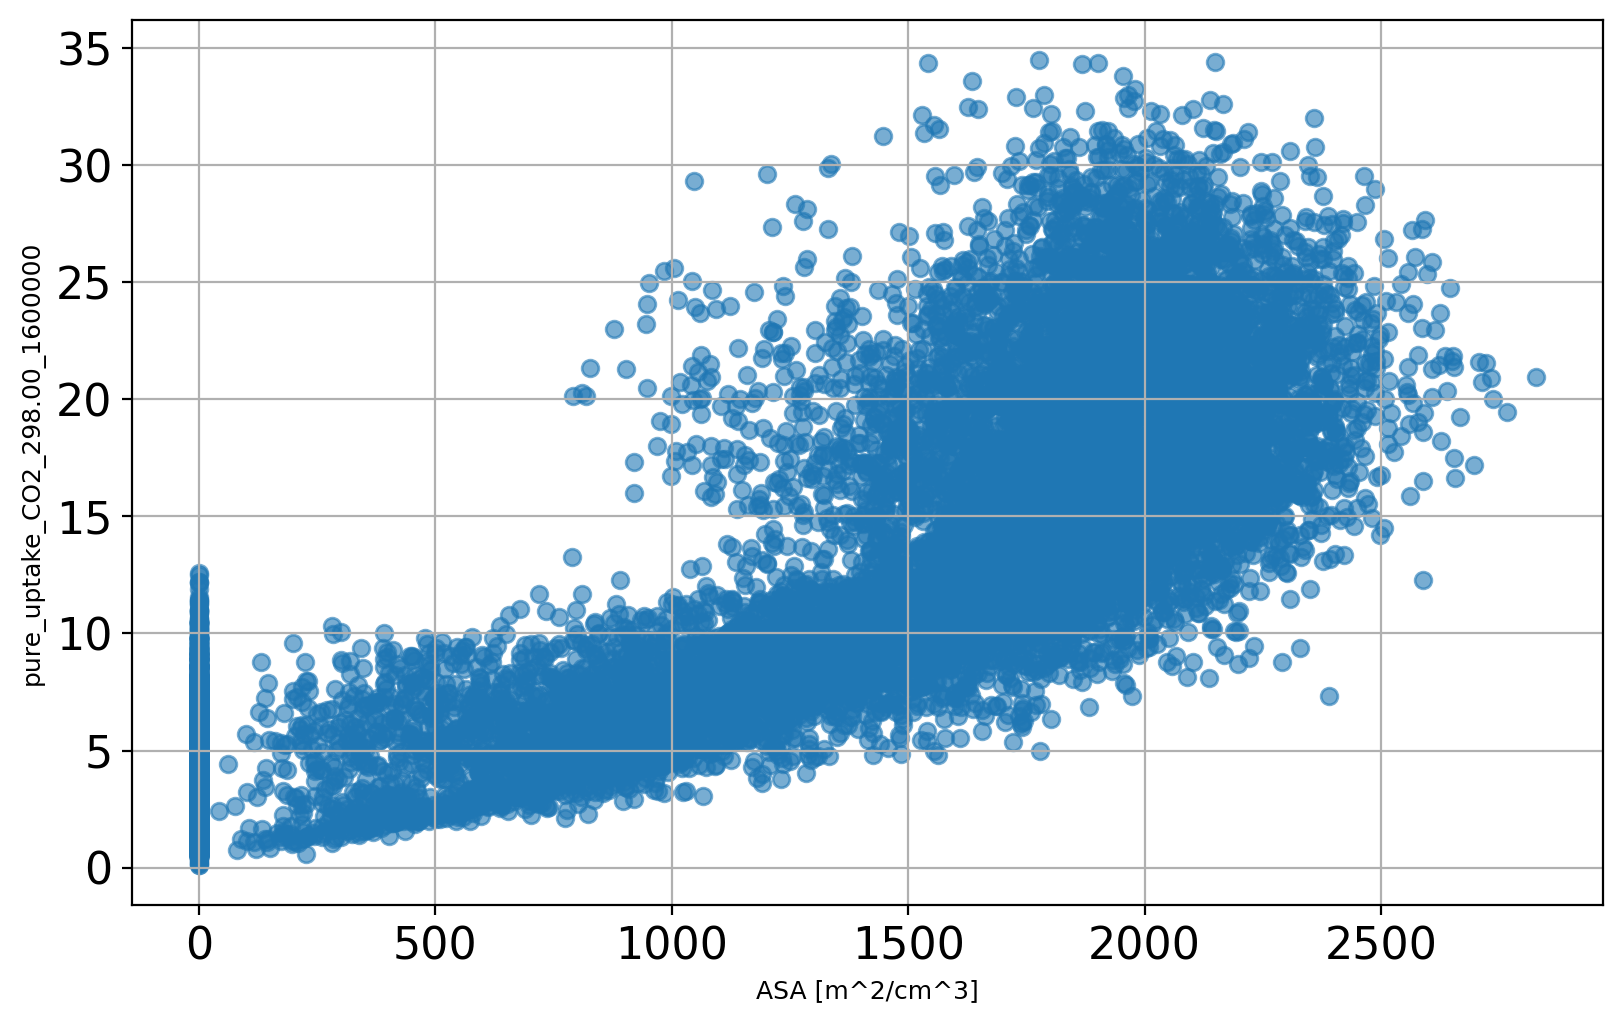

Feature: density [g/cm^3]
  Pearson correlation: -0.8846360549246101
  Spearman correlation: -0.9487270052266709


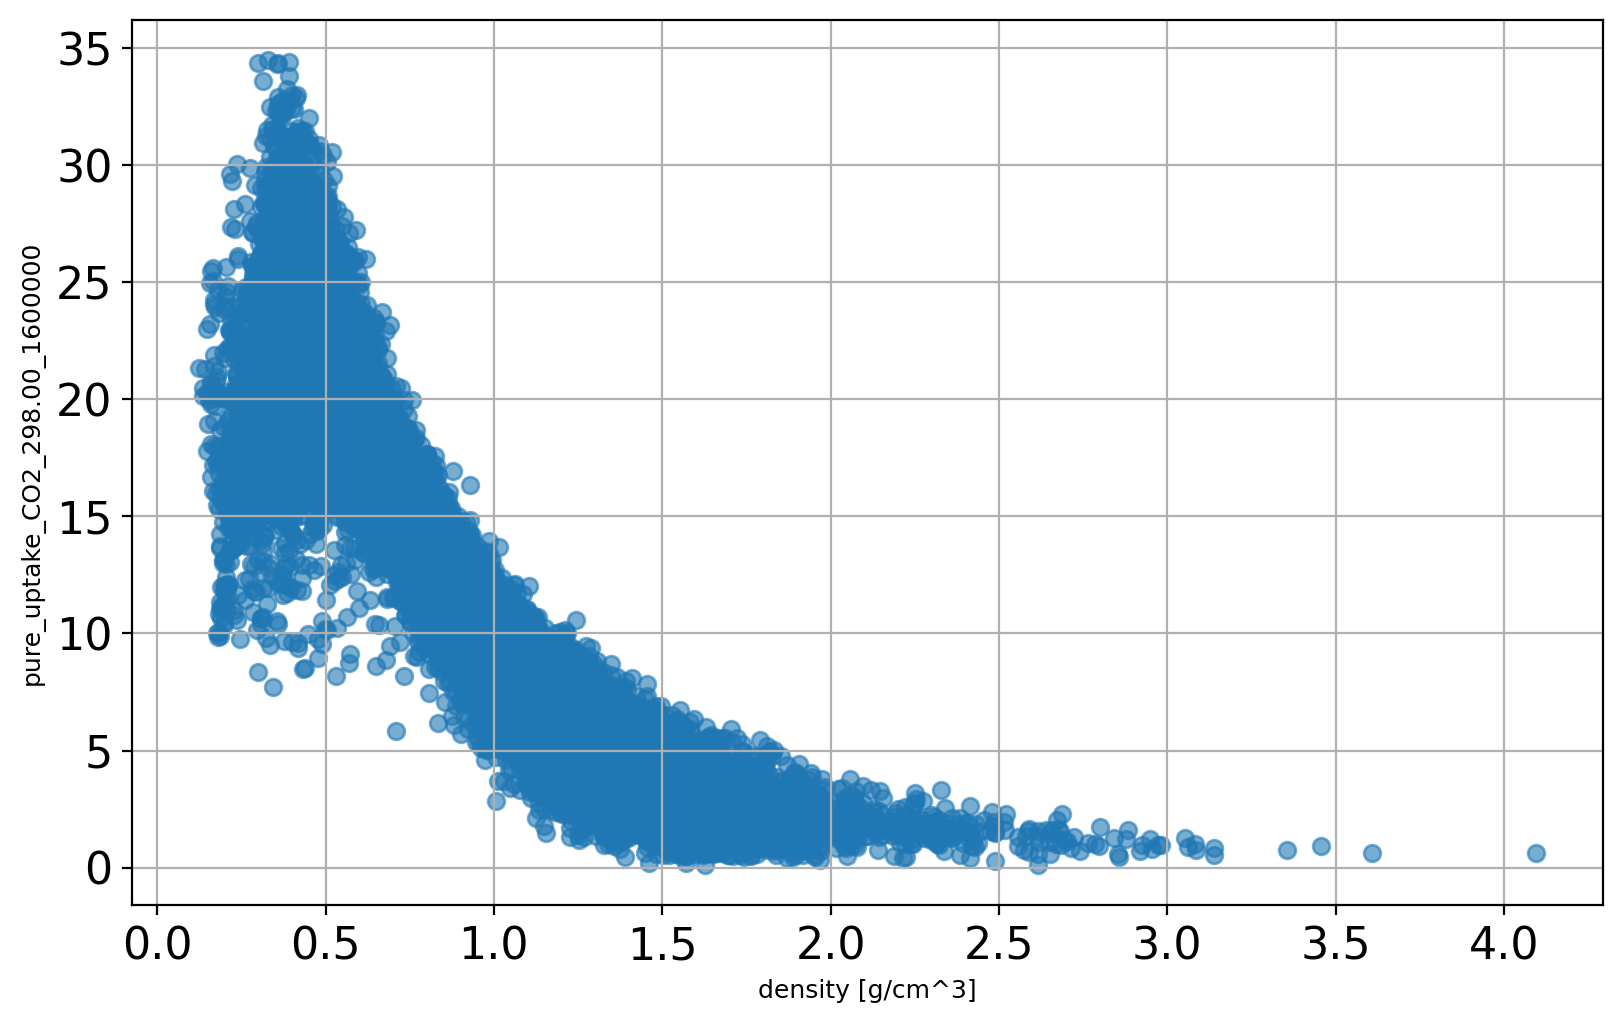

Feature: POAV [cm^3/g]
  Pearson correlation: 0.7867490758533948
  Spearman correlation: 0.9234319927981253


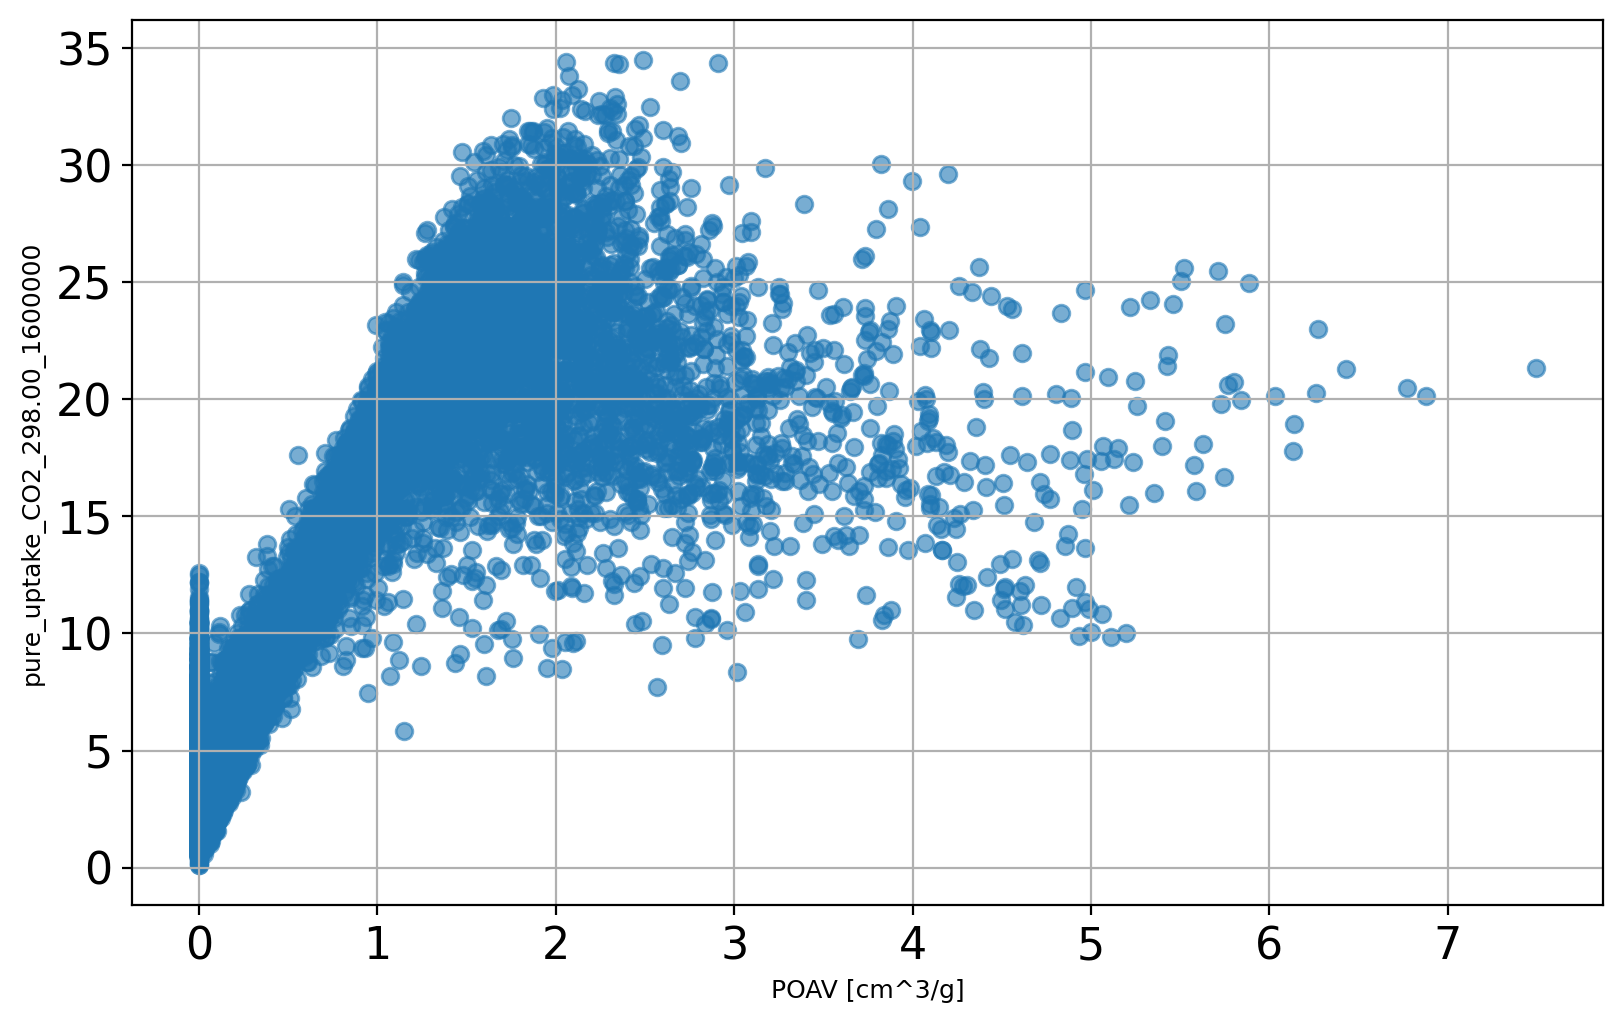

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# Assuming df is your DataFrame
features = ['ASA [m^2/cm^3]', 'density [g/cm^3]', 'POAV [cm^3/g]']
target = 'pure_uptake_CO2_298.00_1600000'

# Calculate and display correlation coefficients
for feature in features:
    pearson_corr, _ = pearsonr(df[feature], df[target])
    spearman_corr, _ = spearmanr(df[feature], df[target])
    
    print(f'Feature: {feature}')
    print(f'  Pearson correlation: {pearson_corr}')
    print(f'  Spearman correlation: {spearman_corr}')
    
    # Scatter plot
    plt.figure(figsize=(8, 5))
    plt.scatter(df[feature], df[target], alpha=0.6)
    #plt.title(f'{feature} vs {target}')
    plt.xlabel(feature, fontsize=9)
    plt.ylabel(target, fontsize=9)
    plt.grid()
    plt.show()

## 4. Baselines

For machine learning, it is important to have some *baselines* to which one then compares the results of a model. Think of a classification model for some rare disease where we only have 1% postives. A classification model that only predictes the negatives *all the time* will still have a amazingly high accuracy. To be able to understand if our model is really better than such a simple prediction we need to make the simple prediction first. This is what we call a baseline.

A baseline could be a really simple model, a basic heuristic or the current state of the art.
this. We will use a heuristic.

For this we use sklearn `Dummy` objects that simply calculate the mean, the median or the most frequent case of the training set, when you run the `fit()` method on them (which takes the features matrix $\mathbf{X}$ and the labels $\mathbf{y}$ as arguments.
This is, the prediction of a `DummyRegressor` with `mean` strategy will always be the mean, independent of the input (it will not look at the feature matrix!). 

Instead of using those `sklearn` objects you could also just manually compute the the mean or median of the dataset. But we will use those objects as we can learn in this way how to use estimators in `sklearn` and it is also allows you to test your full pipeline with different (baseline) models. 
What does this mean? In practice this means that you can use all the regression and classification models shown in the figure below in the same way, they will all have a `fit()` method that accepts `X` and `y` and a predict method that accepts `X` and returns the predictions. 


<img src="https://scikit-learn.org/stable/assets/ml_map.png" alt="ML Map" width="800"/>

The estimator objects can be always used in the same way 

<img src="https://static.packt-cdn.com/products/9781789800265/graphics/d49a2e95-8f22-42ed-89f1-474b3d028787.png" alt="ML Map" width="400"/>

Using these objects, instead of the mean directly, allows you to easily swap them with other models in pipelines, where one chains many data transformation steps (see section 6).

### 4.1. Build dummy models

$\color{DarkBlue}{\textsf{Short Question}}$
- If you call `.fit(X, y)` on a `DummyRegressor` does it actually use the `X`? If not, why is there still the place for the `X` in the function? If yes, how does it use it?

<span style="color:green">Answer:</span>  The `DummyRegressor` does not use the `X` to learn patterns. `X`is included to check if the dimensionality of the two matrices match.

$\color{DarkBlue}{\textsf{Short Exercise}}$
- Create [`DummyRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html) instances for  `mean`, `median`. (e.g. `dummyinstance = DummyRegressor(strategy='mean')`)
- Train them on the training data (`dummyinstance.fit(df_train[FEATURES], df_train[TARGET])`)

<details>
<summary> <font color='green'>Click here for hints</font></summary>
<ul>
    <li> to create <code>DummyRegressor</code> you can for example use <code> dummyregressor_mean = DummyRegressor(strategy='mean') </code> </li>
    <li> to see the implementation of the <code>DummyRegressor</code> you can check out <a href="https://github.com/scikit-learn/scikit-learn/blob/73732e5a0bc9b72c7049dc699d69aaedbb70ef0a/sklearn/dummy.py#L391"> the source code on GitHub</a> </li>
</ul>
</details>

In [23]:
# Build DummyRegressors
dummyregressor_mean = DummyRegressor(strategy='mean')
dummyregressor_median = DummyRegressor(strategy='median')

In [24]:
# Fit Dummy Regressors
dummyregressor_mean.fit(df_train_stratified[FEATURES], df_train_stratified[TARGET])
dummyregressor_median.fit(df_train_stratified[FEATURES], df_train_stratified[TARGET])

DummyRegressor(strategy='median')

#### Evaluate the performance of the dummy models

 $\color{DarkBlue}{\textsf{Short Exercise}}$
- Calculate maximum error, mean absolute error and mean square error for the dummy regressors on training and test set. What would you expect those numbers to be?

<span style="color:green">Answer:</span> Large values are expected as only simple mathematical relations are used to fit the data.
- Do the actual values surprise you?

<span style="color:green">Answer:</span> 

The found values for the maximum error, mean absolute error and mean square error for the mean dummy regressors are:
- For the training set: 'mae': 6.332682697746154, 'mse': 54.36178484567787, 'max_error': 22.60380294886913
- For the testing set: 'mae': 6.27366716404819, 'mse': 53.03274968687297, 'max_error': 22.680388292469132

The found values for the maximum error, mean absolute error and mean square error for the median dummy regressors are:
- For the training set: 'mae': 6.260356674045895, 'mse': 56.256641800406506, 'max_error': 23.980340981299996
- For the testing set: 'mae': 6.183402451368086, 'mse': 54.69101599465944, 'max_error': 24.056926324899997

As the values shown above are large, it does not surprise us.
- What does this mean in practice for reporting of metrics/the reasoning behind using baseline models

<span style="color:green">Answer:</span> The high errors from the `DummyRegressor` are expected, as it only predicts simple values like the mean or median without using any features. These baseline errors help us see if a more complex model actually learns useful patterns. If a model doesn’t perform better than the dummy, it likely isn’t effective.

It can be handy to store our metrics of choice in a nested dictionary ([Python dictionaries are key-value pairs](https://www.tutorialspoint.com/python/python_dictionary.htm)): 

```python
{
    'dummyestimator1': {
                        'metric_a_key': metric_a_value, 
                        'metric_b_key': metric_b_value
                    },
    'dummyestimator2': {
                        'metric_a_key': metric_a_value, 
                        'metric_b_key': metric_b_value
                    },
 }
``` 

You will now write functions `get_regression_metrics(model, X, y_true)` that compute the metrics and return this dictionary for a given model. The `predict` method takes the feature matrix $\mathbf{X}$ as input.

In them, we calculate 

$\mathrm {MAE} =\frac{\sum _{i=1}^{n}\left|Y_{i}-\hat{y}_{i}\right|}{n}.$

and 

$\mathrm {MSE} = {\frac {1}{n}}\sum _{i=1}^{n}(Y_{i}-{\hat {Y_{i}}})^{2}.$ 

where $\hat{y}$ are the predictions and, $Y_{i}$ the true values.

as well as the maximum error.

<details>
<summary> <font color='green'>Click here for hints</font></summary>
<ul>
    <li> to perform a prediction using a estimator object, you can call <code> classifier.predict(X) </code> </li>
    <li> to calculate metrics, you can for example call <code>accuracy_score(true_values, predicted_values) </code> </li>
</ul>
</details>

In [26]:
def get_regression_metrics(model, X, y_true):
    """
    Get a dicionary with regression metrics:

    model: sklearn model with predict method
    X: feature matrix
    y_true: ground truth labels
    """
    y_predicted = model.predict(X)

    mae = mean_absolute_error(y_true, y_predicted)
    mse = mean_squared_error(y_true, y_predicted)
    maximum_error = max_error(y_true, y_predicted)

    metrics_dict = {
        'mae': mae,
        'mse': mse,
        'max_error': maximum_error
    }

    return metrics_dict

In [27]:
dummy_regressors = [
    ('mean', dummyregressor_mean),
    ('median', dummyregressor_median)
]

In [28]:
dummy_regressor_results_test = {} # initialize empty dictionary
dummy_regressor_results_train = {}

# loop over the dummy_regressor list
# if you have a tuple regressorname, regressor = (a, b) that is automatically expanded into the variables
# a = regressorname, b = regressor
for regressorname, regressor in dummy_regressors:
    print(f"Calculating metrics for {regressorname}")
    dummy_regressor_results_test[regressorname] = get_regression_metrics(regressor, df_test_stratified[FEATURES], df_test_stratified[TARGET])
    dummy_regressor_results_train[regressorname] = get_regression_metrics(regressor, df_train_stratified[FEATURES], df_train_stratified[TARGET])

print("Training Metrics:", dummy_regressor_results_train)
print("Testing Metrics:", dummy_regressor_results_test)

Calculating metrics for mean
Calculating metrics for median
Training Metrics: {'mean': {'mae': np.float64(6.332682697746154), 'mse': np.float64(54.361784845677875), 'max_error': np.float64(22.60380294886913)}, 'median': {'mae': np.float64(6.260356674045895), 'mse': np.float64(56.256641800406506), 'max_error': np.float64(23.980340981299996)}}
Testing Metrics: {'mean': {'mae': np.float64(6.27366716404819), 'mse': np.float64(53.03274968687297), 'max_error': np.float64(22.680388292469132)}, 'median': {'mae': np.float64(6.183402451368086), 'mse': np.float64(54.69101599465944), 'max_error': np.float64(24.056926324899997)}}


## 5. Build actual regression models

Let's build a simple [kernel ridge regression (KRR)](https://emtiyaz.github.io/pcml15/kernel-ridge-regression.pdf) machine learning model and train it with our raw data.
You can try different kernels, but we recommend to start with the Gaussian radial basis function ('rbf') kernel.
 
 $\color{DarkBlue}{\textsf{Short Question}}$
- Do you expect this model to perform better than the dummy models?

<span style="color:green">Answer:</span> Yes, one expects this model to be better than the dummy model because it appears to be more advanced and complex.
- Train it and then calculate the performance metrics on the training and test set. How do they compare to the performance of the dummy models?

<span style="color:green">Answer:</span>
The calculated values for the maximum error, mean absolute error and mean square error for this model are:
- For the training set: 'mae': 5.8930721293080754, 'mse': 48.35125984203933, 'max_error': 17.207763399500003
- For the testing set: 'mae': 11.692068235569346, 'mse': 189.94569670655383, 'max_error': 34.4921121426

As it can be seen with the values above, the performance of this model is better for the training set as the values are lower, but worse for the test set.
- What is the shape of the Kernel and of the weights? (you can check your answer by looking at the `dual_coef_` attribute of the KRR instance. You can get shapes of objects using the `shape` atrribute

<span style="color:green">Answer:</span>  The shape of the Kernel and of the weights is a matrix of shape (nb(training point),). The shape is in this case: (12165,). This value comes from the calculation: 0.7 ⋅ 17379, where 0.7 corresponds to the fraction of the dataset used for the training data and 17379 to the number of MOFs in the data set.

In [29]:
# Train the model with a Gaussian kernel
krr = KernelRidge(kernel='rbf')
krr.fit(df_train_stratified[FEATURES], df_train_stratified[TARGET])

KernelRidge(kernel='rbf')

In [31]:
# get the metrics on the train and the test set using the get_regression_metrics functions (as above)
krr_metrics_train = get_regression_metrics(krr, df_train_stratified[FEATURES], df_train_stratified[TARGET])
krr_metrics_test = get_regression_metrics(krr, df_test_stratified[FEATURES], df_test_stratified[TARGET])


print("Kernel Ridge Regression Metrics on Training Set:")
print(krr_metrics_train)

print("\nKernel Ridge Regression Metrics on Test Set:")
print(krr_metrics_test)

Kernel Ridge Regression Metrics on Training Set:
{'mae': np.float64(5.893072129397083), 'mse': np.float64(48.3512598434876), 'max_error': np.float64(17.207763399500003)}

Kernel Ridge Regression Metrics on Test Set:
{'mae': np.float64(11.69206823556942), 'mse': np.float64(189.9456967065587), 'max_error': np.float64(34.4921121426)}


## 6. Evaluate the model performance in detail

We have trained our first machine learning model!
We'll first have a closer look at its performance, before learning how to improve it.

 $\color{DarkBlue}{\textsf{Short Exercise}}$
- Create a parity plot (true values against predictions)for the training and test data
- Plot a histogram of the distribution of the training and test errors on the training and test set. Plot the errors also as a function of the true value
- Let's assume we would like to use our model for pre-screening a library of millions of porous materials to zoom-in on those with the most promising gas uptake. Could you tolerate the errors of your model?
- Compare the parity plots for this model with the ones for the dummy models. 
Use the plotting functions below the evaluate all the following models you train.

For this exercise, it can be handy to save the results in a dictionary, e.g. 
```(python)
res_train = {
    'y true': [],
    'y pred': []
}
```

<details>
<summary> <font color='green'>Click here for hints for plotting</font></summary>
<ul>
    <li> If you want to use matplotlib to make the parity plots, you can use the <a href="https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist2d.html">hist2d function</a> </li>
    <li> To create the frequencies and the edges of a histogram, one can use <code>np.histogram</code></li>
</ul>
</details>

In [33]:
# Create dictionaries with training and test results to create parity plots
res_train = {
    'y true': df_train_stratified[TARGET],
    'y pred': krr.predict(df_train_stratified[FEATURES])
}

res_test = {
    'y true': df_test_stratified[TARGET],
    'y pred': krr.predict(df_test_stratified[FEATURES])
}

Now, lets calculate the errors

In [34]:
res_train["error"] = res_train["y true"] - res_train["y pred"]
res_test["error"] = res_test["y true"] - res_test["y pred"]


Now, plot the parity plots and error distributions

<details>
<summary> <font color='green'>Click here for hints for plotting</font></summary>
If you want interactive plots, you can use the following code:
<pre><code>
hv.extension("bokeh")
hex_train = hv.HexTiles(res_train, ["y true", "y pred"]).hist(
    dimension=["y true", "y pred"]
)
hex_test = hv.HexTiles(res_test, ["y true", "y pred"]).hist(
    dimension=["y true", "y pred"]
)
hex_train + hex_test
</code>
</details>

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
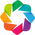

:Layout
   .AdjointLayout.I  :AdjointLayout
      :Overlay
         .HexTiles.I :HexTiles   [y true,y pred]
         .Curve.I    :Curve   [x]   (y)
      :Histogram   [y pred]   (Count)
      :Histogram   [y true]   (Count)
   .AdjointLayout.II :AdjointLayout
      :Overlay
         .HexTiles.I :HexTiles   [y true,y pred]
         .Curve.I    :Curve   [x]   (y)
      :Histogram   [y pred]   (Count)
      :Histogram   [y true]   (Count)

In [35]:
# plot it
import holoviews as hv

hv.extension('bokeh')
hex_train = hv.HexTiles(res_train, ['y true', 'y pred']).hist(dimension=['y true','y pred'])
hex_test = hv.HexTiles(res_test, ['y true', 'y pred']).hist(dimension=['y true', 'y pred'])

x = np.linspace(0,35, 1000)

line_curve = hv.Curve((x, x), 'x', 'y').opts(color='red', line_dash='dashed')



hex_train * line_curve + hex_test* line_curve

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
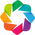

/home/emmaunix/miniconda3/envs/ml_molsim/lib/python3.13/site-packages/bokeh/util/hex.py:145: RuntimeWarning: divide by zero encountered in divide
  x =  x / size * (aspect_scale if orientation == "pointytop" else 1)
/home/emmaunix/miniconda3/envs/ml_molsim/lib/python3.13/site-packages/bokeh/util/hex.py:145: RuntimeWarning: invalid value encountered in multiply
  x =  x / size * (aspect_scale if orientation == "pointytop" else 1)
/home/emmaunix/miniconda3/envs/ml_molsim/lib/python3.13/site-packages/bokeh/util/hex.py:146: RuntimeWarning: divide by zero encountered in divide
  y = -y / size / (aspect_scale if orientation == "flattop" else 1)
/home/emmaunix/miniconda3/envs/ml_molsim/lib/python3.13/site-packages/bokeh/util/hex.py:251: RuntimeWarning: invalid value encountered in cast
  return q.astype(int), r.astype(int)
/home/emmaunix/miniconda3/envs/ml_molsim/lib/python3.13/site-packages/bokeh/util/hex.py:145: RuntimeWarning: divide by zero encountered in divide
  x =  x / size * (aspect_

:Layout
   .AdjointLayout.I  :AdjointLayout
      :Overlay
         .HexTiles.I :HexTiles   [y true,y pred]
         .Curve.I    :Curve   [x]   (y)
      :Histogram   [y pred]   (Count)
      :Histogram   [y true]   (Count)
   .AdjointLayout.II :AdjointLayout
      :Overlay
         .HexTiles.I :HexTiles   [y true,y pred]
         .Curve.I    :Curve   [x]   (y)
      :Histogram   [y pred]   (Count)
      :Histogram   [y true]   (Count)

In [36]:
# Create dictionaries with training and test results to create parity plots for dummy mean model
res_train_dummy_mean = {
    'y true': df_train_stratified[TARGET],
    'y pred': dummyregressor_mean.predict(df_train_stratified[FEATURES])
}

res_test_dummy_mean = {
    'y true': df_test_stratified[TARGET],
    'y pred': dummyregressor_mean.predict(df_test_stratified[FEATURES])
}


res_train_dummy_mean['error'] = res_train_dummy_mean['y true'] - res_train_dummy_mean['y pred'] 
res_test_dummy_mean['error'] = res_test_dummy_mean['y true'] - res_test_dummy_mean['y pred']

# plot it
hv.extension('bokeh')
hex_train_dummy_mean = hv.HexTiles(res_train_dummy_mean, ['y true', 'y pred']).hist(dimension=['y true','y pred'])
hex_test_dummy_mean = hv.HexTiles(res_test_dummy_mean, ['y true', 'y pred']).hist(dimension=['y true', 'y pred'])


line_mean_train = hv.Curve((res_train_dummy_mean['y true'], res_train_dummy_mean['y pred']), 'x', 'y').opts(color='red')
line_mean_test = hv.Curve((res_test_dummy_mean['y true'], res_test_dummy_mean['y pred']), 'x', 'y').opts(color='red')

hex_train_dummy_mean * line_mean_train + hex_test_dummy_mean* line_mean_test

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
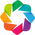

/home/emmaunix/miniconda3/envs/ml_molsim/lib/python3.13/site-packages/bokeh/util/hex.py:145: RuntimeWarning: divide by zero encountered in divide
  x =  x / size * (aspect_scale if orientation == "pointytop" else 1)
/home/emmaunix/miniconda3/envs/ml_molsim/lib/python3.13/site-packages/bokeh/util/hex.py:145: RuntimeWarning: invalid value encountered in multiply
  x =  x / size * (aspect_scale if orientation == "pointytop" else 1)
/home/emmaunix/miniconda3/envs/ml_molsim/lib/python3.13/site-packages/bokeh/util/hex.py:146: RuntimeWarning: divide by zero encountered in divide
  y = -y / size / (aspect_scale if orientation == "flattop" else 1)
/home/emmaunix/miniconda3/envs/ml_molsim/lib/python3.13/site-packages/bokeh/util/hex.py:251: RuntimeWarning: invalid value encountered in cast
  return q.astype(int), r.astype(int)
/home/emmaunix/miniconda3/envs/ml_molsim/lib/python3.13/site-packages/bokeh/util/hex.py:145: RuntimeWarning: divide by zero encountered in divide
  x =  x / size * (aspect_

:Layout
   .AdjointLayout.I  :AdjointLayout
      :Overlay
         .HexTiles.I :HexTiles   [y true,y pred]
         .Curve.I    :Curve   [x]   (y)
      :Histogram   [y pred]   (Count)
      :Histogram   [y true]   (Count)
   .AdjointLayout.II :AdjointLayout
      :Overlay
         .HexTiles.I :HexTiles   [y true,y pred]
         .Curve.I    :Curve   [x]   (y)
      :Histogram   [y pred]   (Count)
      :Histogram   [y true]   (Count)

In [37]:
# Create dictionaries with training and test results to create parity plots for dummy median model
res_train_dummy_median = {
    'y true': df_train_stratified[TARGET],
    'y pred': dummyregressor_median.predict(df_train_stratified[FEATURES])
}

res_test_dummy_median = {
    'y true': df_test_stratified[TARGET],
    'y pred': dummyregressor_median.predict(df_test_stratified[FEATURES])
}


res_train_dummy_median['error'] = res_train_dummy_median['y true'] - res_train_dummy_median['y pred'] 
res_test_dummy_median['error'] = res_test_dummy_median['y true'] - res_test_dummy_median['y pred']

# plot it
hv.extension('bokeh')
hex_train_dummy_median= hv.HexTiles(res_train_dummy_median, ['y true', 'y pred']).hist(dimension=['y true','y pred'])
hex_test_dummy_median = hv.HexTiles(res_test_dummy_median, ['y true', 'y pred']).hist(dimension=['y true', 'y pred'])

line_median_train = hv.Curve((res_train_dummy_median['y true'], res_train_dummy_median['y pred']), 'x', 'y').opts(color='red')
line_median_test = hv.Curve((res_test_dummy_median['y true'], res_test_dummy_median['y pred']), 'x', 'y').opts(color='red')

hex_train_dummy_median * line_median_train + hex_test_dummy_median* line_median_test


## 7. Improve the model 

Our training set still has a couple of issues you might have noticed:
- The feature values are not scaled (different features are measured in different units ...)
- Some features are basically constant, i.e. do not contain relevant information and just increase the dimensionality of the problem 
- Some feature distributions are skewed (which is more relevant for some models than for others ...)

$\color{DarkBlue}{\textsf{Short Question}}$
- Why might the scaling of the features be relevant for a machine learning model? 

### 7.1. Standard scaling and building a first pipeline 

Given that we will now go beyond training a single model, we will build [Pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), which are objects that can collect a selection of transformations and estimators. This makes it quite easy to apply the same set of operations to different datasets. A simple pipeline might be built as follows 

<img src="https://vitalflux.com/wp-content/uploads/2020/08/ML-Pipeline-Page-2-1024x307.png" alt="Pipeline" width="800"/>



 $\color{DarkBlue}{\textsf{Short Exercise}}$
- Build a pipline that first performs standard scaling and then fits a KRR. Call it `pipe_w_scaling`. 
- Fit it on the training set 
- Make predictions, calculate the errors and make the parity plots

<details>
<summary> <font color='green'>Click here for hints</font></summary>
<ul>
    <li> the <code>fit</code>, <code>predict</code> methods also work for pipelines </li>
</ul>
</details>

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
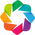

:Layout
   .AdjointLayout.I  :AdjointLayout
      :Overlay
         .HexTiles.I :HexTiles   [y true,y pred]
         .Curve.I    :Curve   [x]   (y)
      :Histogram   [y pred]   (Count)
      :Histogram   [y true]   (Count)
   .AdjointLayout.II :AdjointLayout
      :Overlay
         .HexTiles.I :HexTiles   [y true,y pred]
         .Curve.I    :Curve   [x]   (y)
      :Histogram   [y pred]   (Count)
      :Histogram   [y true]   (Count)

In [38]:
hv.extension('bokeh')

pipe_w_scaling = Pipeline(
   [
       ('scaling', StandardScaler()),
       ('krr', KernelRidge(kernel='rbf'))
   ]
)


# Fit the pipeline on the training set
pipe_w_scaling.fit(df_train_stratified[FEATURES], df_train_stratified[TARGET])

# Calculate errors
res_train = {
    'y true': df_train_stratified[TARGET],
    'y pred': pipe_w_scaling.predict(df_train_stratified[FEATURES])
}

res_test = {
    'y true': df_test_stratified[TARGET],
    'y pred': pipe_w_scaling.predict(df_test_stratified[FEATURES])
}

res_train["error"] = res_train["y true"] - res_train["y pred"]
res_test["error"] = res_test["y true"] - res_test["y pred"]

# Create parity plots
hex_train = hv.HexTiles(res_train, ['y true', 'y pred']).hist(dimension=['y true','y pred'])
hex_test = hv.HexTiles(res_test, ['y true', 'y pred']).hist(dimension=['y true', 'y pred'])

x = np.linspace(0,35, 1000)

line_curve = hv.Curve((x, x), 'x', 'y').opts(color='red', line_dash='dashed')

hex_train * line_curve + hex_test* line_curve #show the combined plot 
    

### 7.2. Hyperparameter optimization

A key component we did not optimize so far are hyperparameters. Those are parameters of the model that we usually cannot learn from the data but have to fix before we train the model. 
Since we cannot learn those parameters it is not trivial to select them. Hence, what we typically do in practice is to create another set, a "validation set", and use it to test models trained with different hyperparameters.

The most common approach to hyperparameter optimization is to define a grid of all relevant parameters and to search over the grid for the best model performance.

$\color{DarkBlue}{\textsf{Short Exercise}}$
- Think about which parameters you could optimize in the pipeline. Note that your KRR model has two parameters you can optimize. You can also switch off some steps by setting them to `None'.
- For each parameter you need to define a resonable grid to search over.
- Recall, what k-fold cross-validation does. Run the hyperparameter optimization using 5-fold cross-validation (you can adjust the number of folds according to your computational resources/impatience. It turns out at k=10 is the [best tradeoff between variance and bias](https://arxiv.org/abs/1811.12808)). 
Tune the hyperparameters until you are statisfied (e.g., until you cannot improve the cross validated error any more)
- Why don't we use the test set for hyperparameter tuning but instead test on the validation set?

<span style="color:green">Answer:</span> The test set needs to stay completely unseen by the model during training so it gives an honest evaluation of performance at the end. If we use the test set for tuning, the model will start to "learn" from it, making the performance results unreliable. Instead, we use the validation set to adjust the model without exposing it to the test data.
- Evaluate the model performance by calculating the performance metrics (MAE, MSE, max error) on the training and the test set.
- *Optional:* Instead of grid search, try to use random search on the same grid (`RandomizedSearchCV`) and fix the number of evaluations (`n_iter`) to a fraction of the number of evaluations of grid search. What do you observe and conclude?

 $\color{DarkRed}{\textsf{Tips}}$
- If you want to see what is happening, set the `verbosity` argument of the `GridSearchCV` object to a higher number.
 
- If you want to speed up the optimization, you can run it in parallel by setting the `n_jobs` argument to the number of workers. If you set it to -1 it will use all available cores. *Using all cores might freeze your computer if you do not have enough memory*
 
- If the optimization is too slow, reduce the number of data points in your set, the number of folds or the grid size. Note that it can also be a feasible strategy to first use a coarser grid and the a finer grid for fine-tuning.

- For grid search, you need to define a parameter grid, which is a dictionary of the following form: 
```(python)
param_grid = {
                    'pipelinestage__parameter': np.logspace(-4,1,10),
                    'pipelinestage': [None, TransformerA(), TransformerB()]
            }
```

- After the search, you can access the best model with `.best_estimator_` and the best parameters with `.best_params_` on the GridSearchCV instance. For example `grid_krr.best_estimator_`

- If you initialize the GridSearchCV instance with `refit=True` it will automatically train the model with all training data (and not only the training folds from cross-validations)

The double underscore (dunder) notation works recursively and specifies the parameters for any pipeline stage. 
For example, `ovasvm__estimator__cls__C` would specifiy the `C` parameter of the estimator in the one-versus-rest classifier `ovasvm`. 

You can print all parameters of the pipeline using `print(sorted(pipeline.get_params().keys()))`

<div class="alert alert-block alert-warning">
Be aware that tight grids will drastically increase the number of experiments you will run! In some cases, it can be useful to perform the optimization in steps, i.e., first use a coarse grid and then refine in interesting regions. 
Alternatively, there are approached like <a href="https://www.jmlr.org/papers/volume18/16-558/16-558.pdf"> hyperband <a> that dynamically adjust the number of data points.
</div>

<details>
<summary> <font color='green'>Click here for hints about pipelines and grid search</font></summary>
<ul>
    <li> You can use the <code>np.logspace</code> function to generate a grid for values that you want to vary on a logarithmic scale </li>
    <li> There are two hyperparameters for KRR: the regularization strength <code>alpha</code> and the Gaussian width  <code>gamma</code> </li>
    <li> For the regularization strength, values between 1 and 1e-3 can be reasonable. For gamma you can use the median heuristic, gamma = 1 / median, or values between 1e-3 and 1e3</li>
</ul>
</details>

In [ ]:
# Define the parameter grid and the grid search object
param_grid = {
                    'scaling': [MinMaxScaler(), StandardScaler()], # test different scaling methods
                    'krr__alpha': #fillme,
                    'krr__#fillme': #fillme
            }

grid_krr = GridSearchCV(#your pipeline, param_grid=param_grid,
                        cv=#number of folds, verbose=2, n_jobs=2)

# optional random search
#random_krr = RandomizedSearchCV(#your pipeline, param_distributions=param_grid, n_iter=#number of evaluations,
#                        cv=#number of folds, verbose=2, n_jobs=2
)

In [ ]:
# run the grid search by calling the fit method
grid_krr.fit(#fillme)
# optional random search
# random_krr.fit(#fillme)

In [ ]:
# get the performance metrics
get_regression_metrics(#fillme)

<details>
<summary> <font color='green'>Click here for some more information about hyperparameter optimization</font></summary>
Grid search is not the most efficient way to perform hyperparamter optimization. Even <a href="http://jmlr.csail.mit.edu/papers/volume13/bergstra12a/bergstra12a.pdf">random search was shown to be more efficient</a>. Really efficient though are Bayesian optimization approaches like <a href='https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)'>TPE</a>. This is implemented in the hyperopt library, which is also installed in your conda environment.
</details>

<details>
<summary> <font color='green'>Click here for hyperparameter optimization with hyperopt (advanded and optional outlook)</font></summary>
    
<b>Import the tools we need</b>
<code>
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, mix, rand, anneal, space_eval
from functools import partial
</code>    

<b>Define the grid</b>
<code>
param_hyperopt = {
    "krr__alpha": hp.loguniform("krr__alpha", np.log(0.001), np.log(10)),
    "krr__gamma": hp.loguniform("krr__gamma", np.log(0.001), np.log(10)),
}
</code> 

<b>Define the objective function</b>
<code>
def objective_function(params):
    pipe.set_params(
        **{
            "krr__alpha": params["krr__alpha"],
            "krr__gamma": params["krr__gamma"],
        }
    )
    score = cross_val_score(
        pipe, X_train, y_train, cv=10, scoring="neg_mean_absolute_error"
    ).mean()
    return {"loss": -score, "status": STATUS_OK} 
</code>

<b>We will use a search in which we mix random search, annealing and tpe</b>
<code>
trials = Trials()
mix_search = partial(
   mix.suggest,
   p_suggest=[(0.15, rand.suggest), (0.15, anneal.suggest), (0.7, tpe.suggest)],
)
</code>

<b>Now, we can minimize the objective function.</b>
<code>
best_param = fmin(
        objective_function,
        param_hyperopt,
        algo=mix_search,
        max_evals=MAX_EVALES,
        trials=trials,
        rstate=np.random.RandomState(RANDOM_SEED),
    )
</code>

</details>

## 8. Feature Engineering 

Finally, we would like to remove features with low variance. This can be done by setting a variance threshold.

$\color{DarkBlue}{\textsf{Short Question}}$
    
- What is the reasoning behind doing this?

<span style="color:green">Answer:</span> Setting a variance threshold reduces model complexity by removing low-variance features, which often carry little useful information. This can help prevent overfitting, especially if low-variance features mainly capture noise.
- When might it go wrong and why?

<span style="color:green">Answer:</span> If the threshold is too high, important features may be removed, potentially losing valuable information. Also, if low-variance features have meaningful correlations with other features, removing them could weaken the model's understanding of the data.

 $\color{DarkBlue}{\textsf{Short Exercise}}$
- Add a variance threshold to the pipeline (select the correct function argument)
- Use random search for hyperparameter optimization, retrain the pipeline, and calculate the performance metrics (max error, MAE, MSE) on the training and test set
- If you could improve the predictive performance, do not forget to also run the model for the Kaggle competition!

In [ ]:
# Define the pipeline
pipe_variance_threshold = Pipeline(
    # fillme with the pipeline steps
    [
        ('variance_treshold', VarianceThreshold(#fillme with threshold)),
        #fillme with remaining pipeline steps
    ]
)

In [ ]:
param_grid_variance_threshold = {
                    'scaling': [None, StandardScaler()],
                    'krr__alpha': #fillme,
                    'krr__#fillme': #fillme,
                    'variance_treshold__threshold': #fillme
            }

random_variance_treshold = RandomizedSearchCV(#your pipeline, param_distributions=param_grid, n_iter=#number of evaluations,
                        cv=#number of folds, verbose=2, n_jobs=2)

In [ ]:
# Fit the pipeline and run the evaluation
random_variance_treshold.fit(#fillme)

$\color{DarkBlue}{\textsf{Short Exercise (optional)}}$
- replace the variance threshold with a model-based feature selection 
`('feature_selection', SelectFromModel(LinearSVC(penalty="l1")))` or [any feature selection method that you would like to try](https://scikit-learn.org/stable/modules/feature_selection.html)

## 9. Saving the model

Now, that we spent so much time in optimizing our model, we do not want to loose it. 

 $\color{DarkBlue}{\textsf{Short Exercise}}$
- use the [joblib library](https://scikit-learn.org/stable/modules/model_persistence.html) to save your model
- make sure you can load it again


In [ ]:
# Dump your model
joblib.dump(model, filename)

In [ ]:
# Try to load it again
model_loaded = joblib.load(filename)

## 10. Influence of Regularization

 $\color{DarkBlue}{\textsf{Short Exercise}}$
- what happens if you set $\alpha$  to a really small or to large value? Why is this the case explain what the parameter means using the equation derived in the lectures?

<span style="color:green">Answer:</span> In Kernel Ridge Regression (KRR), the parameter \( \alpha \) controls the regularization strength. It is included in the loss function as follows:

$$
L = \| y_{ML} - y \|^2_2 + \alpha \| w \|^2_2
$$

- If $\alpha$  is large: The regularization term $\alpha \|w \|^2_2$ heavily penalizes large weights \( w \), resulting in a simpler model that can help prevent overfitting.
- If $\alpha$  is small: The regularization term applies only a small penalty, allowing the model to learn more complex patterns, which increases the risk of overfitting.

To test this, fix this value in one of your pipelines, retrain the models (re-optimizing the other hyperparameters) and rerun the performance evaluation.

<details>
<summary> <font color='green'>Click here for hints</font></summary>
<ul>
    <li> Check the derivation for ridge regression and KRR in the notes. </li>
    <li> Also remember the loss landscapes we discussed in the lectures about LASSO. </li>
</ul>
</details>

## 11. Interpreting the model 

Now, that our model performs decently, we would like to know which features are mainly responsible for this, i.e. how the model performs its reasoning. 

One method to do so is the [permutation feature importance technique](https://christophm.github.io/interpretable-ml-book/feature-importance.html).

$\color{DarkBlue}{\textsf{Short question}}$

We use both descriptors that encode the pore geometry (density, pore diameters, surface areas) as well as some that describe the chemistry of the MOF (the RACs). 
- Would you expect the relative importance of these features to be different for prediction of gas adsorption at high vs low gas pressure?

<details>
<summary> <font color='green'>Click here for a hint</font></summary>
<ul>
    <li> <a href="https://pubs.acs.org/doi/abs/10.1021/acs.chemmater.8b02257">An article from Diego et al.</a> (10.1021/acs.chemmater.8b02257) gives some hints.</li>
</ul>
</details>

 $\color{DarkBlue}{\textsf{Short Exercise}}$
- Complete the function `_calculate_permutation_scores` (which we took from the `sklearn` package) and which is needed to calculate the permutation feature importance using the `permutation_importance` function. 

In [ ]:
def _calculate_permutation_scores(estimator, X, y, col_idx, random_state,
                                  n_repeats, scorer):
    """Calculate score when `col_idx` is permuted. Based on the sklearn implementation

    estimator: sklearn estimator object
    X: pd.Dataframe or np.array
    y: pd.Dataframe or np.array
    col_idx: int
    random_state: int
    n_repeats: int
    scorer: function that takes model, X and y_true as arguments
    """
    random_state = check_random_state(random_state)

    X_permuted = X.copy()
    scores = np.zeros(n_repeats)
    # get the indices
    shuffling_idx = np.arange(X.shape[0])
    for n_round in range(n_repeats):
        # FILL BELOW HERE
        # shuffle them (fill in what you want to shuffle)
        random_state.shuffle(#fillme)

        # Deal with dataframes
        if hasattr(X_permuted, "iloc"):
            # .iloc selects the indices from a dataframe and you give it [row, column]
            col = X_permuted.iloc[shuffling_idx, col_idx]
            col.index = X_permuted.index
            X_permuted.iloc[:, col_idx] = col

        # Deal with numpy arrays
        else:
            # FILL BELOW HERE
            # array indexing is [row, column]
            X_permuted[:, col_idx] = X_permuted[#fillme]

        # Get the scores
        feature_score = scorer(estimator, X_permuted, y)

        # record the scores in array
        scores[n_round] = feature_score

    return scores

Nothing to change in the function below, it just call the `_calculate_permutation_scores` function you just completed. 

In [ ]:
def permutation_importance(
    estimator,
    X,
    y,
    scoring="neg_mean_absolute_error",
    n_repeats=5,
    n_jobs=2,
    random_state=None,
):
    """Permutation importance for feature evaluation
    estimator : object
        An estimator that has already been :term:`fitted` and is compatible
        with :term:`scorer`.
    X : ndarray or DataFrame, shape (n_samples, n_features)
        Data on which permutation importance will be computed.
    y : array-like or None, shape (n_samples, ) or (n_samples, n_classes)
        Targets for supervised or `None` for unsupervised.
    scoring : string, callable or None, default=None
        Scorer to use. It can be a single
        string (see :ref:`scoring_parameter`) or a callable (see
        :ref:`scoring`). If None, the estimator's default scorer is used.
    n_repeats : int, default=5
        Number of times to permute a feature.
    n_jobs : int or None, default=2
        The number of jobs to use for the computation.
        `None` means 1 unless in a :obj:`joblib.parallel_backend` context.
        `-1` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.
    random_state : int, RandomState instance, or None, default=None
        Pseudo-random number generator to control the permutations of each
        feature. See :term:`random_state`.
    """
    # Deal with dataframes
    if not hasattr(X, "iloc"):
        X = check_array(X, force_all_finite="allow-nan", dtype=None)

    # Precompute random seed from the random state to be used
    # to get a fresh independent RandomState instance for each
    # parallel call to _calculate_permutation_scores, irrespective of
    # the fact that variables are shared or not depending on the active
    # joblib backend (sequential, thread-based or process-based).
    random_state = check_random_state(random_state)
    random_seed = random_state.randint(np.iinfo(np.int32).max + 1)

    # Determine scorer from user options.
    scorer = check_scoring(estimator, scoring=scoring)
    # get the performance score on the unpermuted data
    baseline_score = scorer(estimator, X, y)

    # run the permuted evaluations in parallel for each column
    scores = Parallel(n_jobs=n_jobs)(
        delayed(_calculate_permutation_scores)(
            estimator, X, y, col_idx, random_seed, n_repeats, scorer
        )
        for col_idx in range(X.shape[1])
    )

    # get difference two
    importances = baseline_score - np.array(scores)

    # return the results (dictionary)
    return Bunch(
        importances_mean=np.mean(importances, axis=1),
        importances_std=np.std(importances, axis=1),
        importances=importances,
    )


 $\color{DarkBlue}{\textsf{Short Exercise}}$
- Use your function to find the five most important features.
- Which are they? Did you expect this result?

In [ ]:
permutation_results = permutation_importance(#fillme)

In [ ]:
permutation_results["features"] = FEATURES
bars = hv.Bars(
    permutation_results, "features", ["importances_mean", "importances_std"]
).sort("importances_mean", reverse=True)
errors = hv.ErrorBars(
    permutation_results, "features", vdims=["importances_mean", "importances_std"]
).sort("importances_mean", reverse=True)

bars * errors


<details>
<summary> <font color='green'>Click here for hints</font></summary>
<ul>
    <li> To get the top <emph>n</emph> indices of an array <code>a</code>, you can use <code>np.argsort(a)[-n:]</code></li>
    <li> Get the feature names from the <code>FEATURES</code> list </li> 
    <li> combined this might look like <code>np.array(FEATURES)[np.argsort(a)[-n:]]</code></li>
</ul>
</details>

<details>
<summary> <font color='green'>Click here for more information on model interpretation</font></summary>
The permutation feature importance technique is not a silver bullet, e.g. there are issues with correlated features.
However, it is likely <a href='https://explained.ai/rf-importance/'>a better choice than feature importance, like impurity decrease, derived from random forests</a>).
</details>

## 12. Submit your best model to Kaggle 

Join the [Kaggle competition](https://www.kaggle.com/competitions/molsim-2024-ml-challenge/host/launch-checklist) for this course!
For this you can: 
- try to continue optimizing your KRR model 
- try to use a new model ([browse the sklearn documentation](https://scikit-learn.org/) for ideas or check out [xgboost](https://xgboost.readthedocs.io/en/stable/)

The important parts for us here are: 
- that you make an attempt to improve your model, discuss this attempt, and use proper models to measure potential improvement 
- we will not grade you based on how "fancy" or model is or how well it performs but rather on whether you do something reasonable that is well motivated in your discussion
- you do not need to try both a model and continue optimizing your model. Doing one of them is, in principle, "enough"

Use then your best model to create a `submission.csv` with your predictions to join the competition and upload it to the competition site.


In [ ]:
kaggle_data = pd.read_csv('data/features.csv')
kaggle_predictions = #fillme.predict(kaggle_data[FEATURES])

In [ ]:
submission = pd.DataFrame({"id": kaggle_data["id"], "prediction": kaggle_predictions})

submission.to_csv("submission.csv", index=False)
